# Setup:
Mounting Drive, Creation main path, and directing the Colab to this path


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

main_directory = os.path.join('drive/MyDrive/Colab Notebooks/projects/LanguageIdentification')

Mounted at /content/drive


In [ ]:
def check_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
check_dir(main_directory)

In [ ]:
%cd drive/MyDrive/Colab Notebooks/projects/LanguageIdentification

/content/drive/MyDrive/Colab Notebooks/projects/LanguageIdentification


# **Import required dependencies**

In [ ]:
!pip install datasets

from datasets import load_dataset
import pandas as pd
import re
import nltk
import os
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random
nltk.download('punkt')

from string import punctuation
from torch import nn
from nltk import word_tokenize
from tqdm import tqdm
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, confusion_matrix
from collections import Counter

random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Data Processing and Vocabulary**

In [ ]:
class Preprocess:
    """
    Class is utilized to perform the preprocessing phase.
    Initially text is cleaned then tokenization or n-gram generation is applied according to the user's choice.
    Notice that, class works based on input text, which is easily applicable by pandas DataFrames.
    """

    def __init__(self, use_words: bool = False, window_size: int = 3, window_shift: int = 2, remove_html: bool = True,
                 remove_numbers: bool = True, remove_punctuation: bool = True, lower_case: bool = True):
        """
        Initializer for the class which specifies required parameters
        :param use_words: boolean to determine word-based or ngram-based tokenization will be performed
        :param window_size: integer to determine ngram size
        :param window_shift: integer to determine skipping step in ngram-based tokenization
        :param remove_html: boolean to determine removing (True) html tags from the given text
        :param remove_numbers: boolean to determine removing (True) numbers from the given text
        :param remove_punctuation: boolean to determine removing (True) punctuation elements from the given text
        :param lower_case: boolean to lower-case (True) the given text
        """
        self.use_words = use_words
        self.window_size = window_size
        self.window_shift = window_shift
        self.remove_html = remove_html
        self.remove_numbers = remove_numbers
        self.remove_punctuation = remove_punctuation
        self.lower_case = lower_case

    def extract_features(self, input_text: str) -> list:
        """
        Method is used to extract resulting features from the given text (words or ngrams)
        :param input_text: raw text to be processed (string)
        :return: list of features for the given text
        """
        return word_tokenize(input_text) if self.use_words else self.create_windows(input_text)

    def create_windows(self, input_text: str) -> list:
        """
        Method is used to extract ngram features according to the given size and shift values
        :param input_text: text to be processed (string)
        :return: list of ngrams which are extracted from the given text
        """
        length = len(input_text)
        windows = list()
        for idx in range(0, length, self.window_shift):
            window = input_text[idx: idx + self.window_size]
            if len(window) == self.window_size:
                windows.append(window)
        return windows

    def process_data(self, input_text: str) -> list:
        """
        Method is utilized to perform each step of preprocessing, sequentially.
        Initially, cleaning is performed (e.g., html, number and punctuation removal).
        Resulting text is sent to tokenization which considers word-based or ngram-based tokenization.
        :param input_text: raw text to be processed (string)
        :return: list of tokens as a result of preprocessing
        """
        result_text = input_text
        if self.remove_html:
            html_regex = re.compile(r'<[^>]+>')
            result_text = html_regex.sub('', result_text)
        if self.remove_numbers:
            num_regex = re.compile(r'[0-9]')
            result_text = num_regex.sub('', result_text)
        if self.remove_punctuation:
            result_text = ''.join([each_token for each_token in result_text if each_token not in punctuation])
        if self.lower_case:
            result_text = result_text.lower()
        features = self.extract_features(result_text)
        return features


In [ ]:
class Vocabulary:
    """
    Class is utilized to generate not only vocabulary based on the dataset, but also used to encode
    features and labels.
    """

    def __init__(self, source_dir: str, use_words: bool = False):
        """
        Initializer for the class which specifies required parameters
        :param source_dir: directory where vocabulary is saved (vocabulary saving might be vital for further works)
        :param use_words: boolean to determine word-based or ngram-based encoding will be performed
        """
        self.source_dir = source_dir
        self.use_words = use_words
        self.vocabulary, self.labels = self.get_vocab()

    def get_dataset(self) -> pd.DataFrame:
        """
        Method is utilized to collect train dataset for vocabulary creation
        :return: train dataset
        """
        ds_path = os.path.join(self.source_dir, 'raw_data.pickle')
        with open(ds_path, 'rb') as raw_ds:
            datasets = pickle.load(raw_ds)
        return datasets['train']

    def get_unique(self) -> tuple:
        """
        Method is utilized to extract unique features and labels from dataset
        :return: tuple object which carries set of unique tokens (words or ngrams) and list of unique labels
        """
        train_set = self.get_dataset()
        labels = train_set['labels'].unique()
        unique_tokens = list()
        for text in train_set['tokenized']:
            unique_tokens.extend(text)
        return set(unique_tokens), labels

    def generate_vocabulary(self) -> tuple:
        """
        Method is utilized to generate vocabulary and 'label to index' dictionary.
        :return: tuple object which carries vocabulary and label dictionaries
        """
        tokens, labels = self.get_unique()
        vocabulary = {token: idx for idx, token in enumerate(tokens)}
        vocabulary['<PAD>'] = len(vocabulary)
        vocabulary['<UNK>'] = len(vocabulary)
        lab2idx = {label: idx for idx, label in enumerate(labels)}
        return vocabulary, lab2idx

    def get_vocab(self) -> tuple:
        """
        Method performs all steps as a main function. If vocabulary was already generated, it will load it.
        Otherwise, all steps will be performed.
        This idea is vital, since vocabulary loading might be vital for further uses: independent inference process,
        resuming training for further refinements
        :return: tuple object which carries vocabulary and label dictionaries
        """
        check_dir(self.source_dir)
        vocab_info_file = f"vocab_info_{'words' if self.use_words else 'ngrams'}.pickle"
        vocab_path = os.path.join(self.source_dir, vocab_info_file)
        if vocab_info_file not in os.listdir(self.source_dir):
            vocabulary, lab2idx = self.generate_vocabulary()
            vocab_info = {
                'vocabulary': vocabulary,
                'lab2id': lab2idx
            }

            with open(vocab_path, 'wb') as vocab_info_data:
                pickle.dump(vocab_info, vocab_info_data)
        with open(vocab_path, 'rb') as vocab_info_data:
            vocab_info = pickle.load(vocab_info_data)

        return vocab_info['vocabulary'], vocab_info['lab2id']

    def __getitem__(self, token: str) -> int:
        """
        Method is utilized to encode the provided token
        :param token: any feature to be extracted. In case it does not exist in vocabulary, index of '<UNK>' will be
                      returned (OOV tokens)
        :return: corresponding index for provided token in the vocabulary
        """
        return self.vocabulary[token] if token in self.vocabulary.keys() else self.vocabulary['<UNK>']

    def lab2id(self, label: str) -> int:
        """
        Method is utilized to encode labels in the dataset
        :param label: language symbol for specific data
        :return: corresponding class number for the given label
        """
        return self.labels[label]

    def __len__(self):
        """
        Method is utilized to provide length of vocabulary (will be used for embedding layer)
        :return: number of features in the vocabulary
        """
        return len(self.vocabulary)


In [ ]:
class PostProcess:
    """
    Class is utilized to make data ready for dataset creation for the model. This phase was separated from
    initial preprocessing, because of vocabulary generation must be made with raw data, before this phase.
    (Several ways exist, but we prefer granular and step by step performance)
    """

    def __init__(self, preprocess: Preprocess, vocabulary: Vocabulary, max_length: int):
        """
        Initializer for the class which specifies required parameters
        :param preprocess: Preprocess object will be used for dataset structure
        :param vocabulary: Vocabulary object will be used for data encoding
        :param max_length: maximum length of sequence (will be required by model)
        """
        self.preprocess = preprocess
        self.vocabulary = vocabulary
        self.max_length = max_length

    def set_length(self, text: list) -> list:
        """
        Method is utilized to set all sequences in the length of maximum length. If sequence is longer than it,
        then it will be truncated. Otherwise, sequence will be padded to the maximum length
        :param text: list of extracted features for one text
        :return: list of features in length of maximum length
        """
        if len(text) > self.max_length:
            return text[0: self.max_length]
        else:
            padded_text = text + ['<PAD>'] * (self.max_length - len(text))
            return padded_text

    def encode_text(self, input_text: list) -> list:
        """
        Method is utilized to encode each feature according to the generated vocabulary.
        :param input_text: list of features to be encoded
        :return: list of corresponding indexes per each feature in the given list
        """
        text = self.set_length(input_text)
        return [self.vocabulary[token] for token in text]

    def save_structure(self) -> None:
        """
        Method is utilized to save dataset information, in order to make tracking possible
        :return: None
        """
        ds_info_data = f"dataset_info.pickle"
        if ds_info_data not in os.listdir(self.vocabulary.source_dir):
            dataset_info = {
                'max_length': self.max_length,
                'use_words': self.preprocess.use_words,
                'window_size': self.preprocess.window_size,
                'window_shift': self.preprocess.window_shift
            }
            dataset_path = os.path.join(self.vocabulary.source_dir, ds_info_data)
            with open(dataset_path, 'wb') as ds_data:
                pickle.dump(dataset_info, ds_data)

    def process_dataset(self, dataset: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
        """
        This specific method performs dataset processing for model.
        :param dataset: dataset in form of DataFrame (makes applying functions simple)
        :param dataset_name: name of dataset which is required to save and load data
        :return: specific dataset (train, validation, test)
        """
        self.save_structure()
        ds_file = f"{dataset_name}.pickle"
        ds_path = os.path.join(self.vocabulary.source_dir, ds_file)
        if ds_file not in os.listdir(self.vocabulary.source_dir):
            dataset['encoded'] = dataset['tokenized'].apply(self.encode_text)
            dataset['label'] = dataset['labels'].apply(self.vocabulary.lab2id)
            with open(ds_path, 'wb') as data:
                pickle.dump(dataset, data)
        with open(ds_path, 'rb') as data:
            dataset = pickle.load(data)
        return dataset


# **Dataset Object**

In [ ]:
class LangID(Dataset):
    def __init__(self, dataset, device):
        self.device = device
        self.data, self.label = self.get_dataset(dataset)

    def get_dataset(self, dataset):
        data = list(dataset['encoded'])
        labels = list(dataset['label'])
        return torch.LongTensor(data).to(self.device), torch.LongTensor(labels).to(self.device)

    def __getitem__(self, idx):
        return {
            'data': self.data[idx],
            'label': self.label[idx]
        }

    def __len__(self):
        return len(self.label)

# **To build the classifier model**

In [ ]:
class LangClassifier(nn.Module):
    """
    Class is used to build the classifier model
    """

    def __init__(self, hyperparams: dict, vocabulary: Vocabulary):
        """
        Initializer for the class which specifies required parameters
        :param hyperparams: dictionary for hyperparameters of the model
        :param vocabulary: vocabulary object will be used for embedding layer and padding index
        """
        super(LangClassifier, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=len(vocabulary),
            embedding_dim=hyperparams['emb_dim'],
            padding_idx=vocabulary['<PAD>']
        )
        self.lstm = nn.LSTM(
            input_size=hyperparams['emb_dim'],
            hidden_size=hyperparams['hid_dim'],
            bidirectional=hyperparams['bidirectional'],
            num_layers=hyperparams['num_layers'],
            batch_first=True
        )

        input_dim = hyperparams['hid_dim'] * 2 if hyperparams['bidirectional'] else hyperparams['hid_dim']
        self.dense = nn.Flatten()
        self.linear = nn.Linear(
            in_features=hyperparams['max_length'] * input_dim,
            out_features=hyperparams['num_classes']
        )
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_data: torch.LongTensor) -> torch.Tensor:
        """
        Method is utilized to perform feedforward process
        :param input_data: input tensor for the model
        :return: output of the model
        """
        embeddings = self.embedding(input_data)
        lstm_out, (_, _) = self.lstm(embeddings)
        relu_out1 = self.relu1(lstm_out)
        dense_out = self.dense(relu_out1)
        dp_out = self.dropout(dense_out)
        relu_out = self.relu2(dp_out)
        out = self.linear(relu_out)
        return out


# **Train object for training, development and test phases**

In [ ]:
class Train:
    """
    Class is used for training process. It not only performs each phase of training also keeps track of results
    per epoch. Notice that model and optimizer parameters are also saved by this class.
    """

    def __init__(self, preprocess: Preprocess, vocabulary: Vocabulary, hyperparams: dict, exp_num: int, device: str,
                 resume_training: bool = False, load_best: bool = False, choice: str = 'f1_score',
                 epoch_choice: int = 0):
        """
        Initializer for the class which specifies required parameters
        :param preprocess: Preprocess object will be consumed by post-process object
        :param vocabulary: Vocabulary object will be consumed by post-process object
        :param hyperparams: hyperparameters for model and post-process object
        :param exp_num: experiment number for saving experiment results in specific folder
        :param device: device for model training (can be cuda or cpu)
        :param resume_training: boolean variable determines whether resume from the specific (or the last) epoch
        :param load_best: boolean variable specifies whether model parameters will be loaded based on best performance
        :param choice: choice of the best performance (f1_score, dev_loss, dev_accuracy)
        :param epoch_choice: epoch choice for model parameter loading (can also be used for resume training)
        """
        self.prep = preprocess
        self.hp = hyperparams
        self.device = device
        self.exp_dir = self.create_directory(exp_num)
        self.resume_training = resume_training
        self.load_best = load_best
        self.choice = choice
        self.epoch_choice = epoch_choice

        self.processing = PostProcess(preprocess, vocabulary, hyperparams['max_length'])
        self.model = self.set_model(vocabulary)
        self.optimizer = self.set_optimizer()
        self.loss_fn = nn.CrossEntropyLoss()

    def set_model(self, vocabulary: Vocabulary) -> LangClassifier:
        """
        Method is utilized to set initialize the model
        :param vocabulary: vocabulary object
        :return: classifier object
        """
        return LangClassifier(hyperparams=self.hp, vocabulary=vocabulary).to(self.device)

    def set_optimizer(self) -> Adam:
        """
        Method is utilized to set optimizer
        :return: Adam optimizer
        """
        return Adam(
            params=self.model.parameters(),
            lr=self.hp['learning_rate'],
            weight_decay=self.hp['weight_decay']
        )

    def create_directory(self, exp_num: int) -> str:
        """
        Method is utilized to create experiment folder which will be used by class for data tracking
        :param exp_num: experiment number
        :return: experiment directory for further uses
        """
        results_dir = 'results'
        check_dir(results_dir)
        experiment_folder = os.path.join(results_dir, f'experiment_{exp_num}')
        check_dir(experiment_folder)
        hp_file = os.path.join(experiment_folder, 'hyperparams.pickle')
        with open(hp_file, 'wb') as hp_save_data:
            pickle.dump(self.hp, hp_save_data)
        return experiment_folder

    def get_data(self, datasets: dict, ds_name: str) -> tuple:
        """
        Method is utilized to get batches and number of instances of the dataset, which is specified by its name
        :param datasets: dictionary of all datasets
        :param ds_name: specific dataset name (train, validation, test)
        :return: tuple of data loader object and length of specific dataset
        """
        data = self.processing.process_dataset(datasets[ds_name], ds_name)
        dataset = LangID(data, self.device)
        return DataLoader(dataset=dataset, batch_size=self.hp['batch_size'], shuffle=True), dataset.__len__()

    def train_step(self, train_batch: dict) -> tuple:
        """
        Method is used to perform each step of the corresponding epoch
        :param train_batch: dictionary which includes data and labels for corresponding batch
        :return: tuple of model's output tensor and step loss value
        """
        output = self.model(train_batch['data'])
        loss = self.loss_fn(output, train_batch['label'])
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return output, loss.item()

    @staticmethod
    def compute_accuracy(batch_data: dict, output: torch.Tensor) -> tuple:
        """
        Method is utilized to compute accuracy at each step of the corresponding epoch
        :param batch_data: dictionary which includes data and labels for corresponding batch
        :param output: tensor for model's output
        :return: tuple which includes following information:
                 correct: number of correct predictions per step
                 predictions: list which includes model's output per given batch
                 targets: list which includes target values per given batch
        """
        predictions = torch.argmax(output, -1).tolist()
        targets = batch_data['label'].tolist()
        correct = sum([t == p for t, p in zip(targets, predictions)])
        return correct, predictions, targets

    def development(self, dev_loader: DataLoader, dev_instances: int, epoch: int, type_out: str = 'test') -> tuple:
        """
        Method is utilized to perform validation after each epoch of training
        :type epoch: parameter specifies the current epoch
        :param dev_loader: DataLoader object for validation dataset
        :param dev_instances: number of instances for validation dataset
        :param type_out: defines whether data is validation or test dataset
        :return: tuple object which includes following information:
                 dev_avg_loss: average loss for validation phase
                 dev_accuracy: accuracy (in percents) for validation phase
                 f1_macro: f1 score with macro average
        """
        dev_epoch_loss = 0
        dev_epoch_accuracy = 0
        self.model.eval()
        predictions = list()
        targets = list()
        num_batches = len(dev_loader)
        word_choice = 'Validation' if type_out == 'dev' else 'Test'
        with torch.no_grad():
            dev_iter = tqdm(dev_loader, total=num_batches, leave=True)
            for dev_batch in dev_iter:
                output = self.model(dev_batch['data'])
                dev_step_loss = self.loss_fn(output, dev_batch['label'])
                dev_step_accuracy, batch_predictions, batch_targets = self.compute_accuracy(dev_batch, output)
                dev_epoch_loss += dev_step_loss.item()
                dev_epoch_accuracy += dev_step_accuracy
                predictions.extend(batch_predictions)
                targets.extend(batch_targets)

                dev_iter.set_description(f"{word_choice} Loss: {dev_epoch_loss / num_batches: .4f}; "
                                         f"{word_choice} Accuracy: {dev_epoch_accuracy / dev_instances: .4f}")
        f1_macro = f1_score(targets, predictions, average='macro')
        dev_avg_loss = dev_epoch_loss / num_batches
        dev_accuracy = dev_epoch_accuracy / dev_instances
        out_dict = {'predictions': predictions, 'targets': targets}
        self.save_outputs(out_dict, epoch, type_out)
        return dev_avg_loss, dev_accuracy, f1_macro

    def training(self, datasets: dict, epochs: int = 5) -> None:
        """
        Method is utilized to perform training phase
        :param datasets: dictionary of all datasets
        :param epochs: number of epochs that model will be trained
        :return: None
        """
        train_loader, train_instances = self.get_data(datasets, 'train')
        dev_loader, dev_instances = self.get_data(datasets, 'validation')
        num_train_batches = len(train_loader)
        init_epoch = self.load_model_parameters() if self.resume_training else 0
        for epoch in range(init_epoch, epochs):
            self.model.train()
            epoch_train_loss = 0
            epoch_train_accuracy = 0
            train_iterator = tqdm(train_loader, total=num_train_batches, leave=True)
            for batch in train_iterator:
                output, train_step_loss = self.train_step(batch)
                epoch_train_loss += train_step_loss
                train_step_accuracy, _, _ = self.compute_accuracy(batch, output)
                epoch_train_accuracy += train_step_accuracy
                train_iterator.set_description(f"Epoch: {epoch + 1} "
                                               f"Train Loss: {epoch_train_loss / num_train_batches: .4f} "
                                               f"Train Accuracy: {epoch_train_accuracy / train_instances: .4f}")
            dev_loss, dev_accuracy, f1 = self.development(dev_loader, dev_instances, epoch, 'dev')

            epoch_results = {
                'epoch': epoch + 1,
                'train_loss': epoch_train_loss / num_train_batches,
                'dev_loss': dev_loss,
                'train_accuracy': epoch_train_accuracy / train_instances,
                'dev_accuracy': dev_accuracy,
                'f1_score': f1
            }
            self.save_results(epoch_results)
            self.save_model_parameters(epoch_results)
        test_loader, test_instances = self.get_data(datasets, 'test')
        test_loss, test_accuracy, test_f1 = self.development(test_loader, test_instances, 100, 'test')
        print(f'Test Results after {epochs} epochs: Test Loss: {test_loss: .4f}, Test Accuracy: {test_accuracy: .4f},'
              f'f1 score: {test_f1: .4f}')

    def save_outputs(self, output_dict: dict, epoch: int, type_out: str = 'dev'):
        output_dir = os.path.join(self.exp_dir, 'outputs')
        check_dir(output_dir)
        out_file = os.path.join(output_dir, f'epoch_{epoch + 1}_{type_out}_output.pickle')
        with open(out_file, 'wb') as out_data:
            pickle.dump(output_dict, out_data)

    def save_results(self, epoch_data: dict) -> None:
        """
        Method is utilized to save training and validation results per epoch
        :param epoch_data: dictionary which includes all relevant information as a result of epoch
        :return: None
        """
        train_results_file = os.path.join(self.exp_dir, 'train_results.pickle')

        if not os.path.exists(train_results_file):
            results_dict = {data: list() for data in epoch_data.keys()}
        else:
            with open(train_results_file, 'rb') as train_data:
                results_dict = pickle.load(train_data)
        for data, value in epoch_data.items():
            results_dict[data].append(value)
        with open(train_results_file, 'wb') as train_data:
            pickle.dump(results_dict, train_data)
        print(f"Train and Validation results were added to data for {epoch_data['epoch']}")

    def save_model_parameters(self, epoch_data: dict):
        """
        Method is utilized to save model and optimizer parameters after each epoch
        :param epoch_data: dictionary which includes all relevant information as a result of epoch
        :return: None
        """
        checkpoints_dir = os.path.join(self.exp_dir, 'checkpoints')
        check_dir(checkpoints_dir)
        model_name = f"model_ep_{epoch_data['epoch']}_f1_{epoch_data['f1_score']: .5f}_" \
                     f"devacc_{epoch_data['dev_accuracy']: .5f}"
        model_path = os.path.join(checkpoints_dir, model_name)
        optim_name = f"optim_ep_{epoch_data['epoch']}"
        optim_path = os.path.join(checkpoints_dir, optim_name)
        torch.save(self.model.state_dict(), model_path)
        torch.save(self.optimizer.state_dict(), optim_path)
        print(f"Model and optimizer parameters were saved successfully for {epoch_data['epoch']}")
        print(20 * '<', 20 * '>')

    def load_best_choice(self, results_frame: pd.DataFrame) -> pd.DataFrame:
        """
        Method is utilized for simplifying process (in granular approach). Mainly it specifies on what the best
        choice will be made and returns the corresponding subset of the results data frame
        :param results_frame: dataframe which includes all relevant results for all epochs
        :return: dataframe which is specific subset of the provided one
        """
        optimal_choice = results_frame[self.choice].max() if self.choice != 'dev_loss' \
            else results_frame[self.choice].min()

        print(f"Model was chosen according to {self.choice}")
        return results_frame[results_frame[self.choice] == optimal_choice]

    def load_epoch(self, results_frame: pd.DataFrame) -> pd.DataFrame:
        """
        Method is utilized for simplifying process (in granular approach). Mainly it determines subset will be chosen
        whether for specific epoch choice or the last epoch
        :param results_frame: dataframe which includes all relevant results for all epochs
        :return: dataframe which is specific subset of the provided one
        """
        if not self.epoch_choice:
            print('No specific epoch was chosen. Thus, the latest epoch parameters will be loaded')

        choice = results_frame[results_frame['epoch'] == self.epoch_choice] if self.epoch_choice else \
            results_frame[results_frame['epoch'] == results_frame['epoch'].max()]
        return choice

    def load_model_parameters(self) -> int:
        """
        Method is used for loading model parameters. Mainly it does following:
        1. Check if such results data exists. If it does not, it means there was not any training. Ends with error.
        2. If such data exists, then dataframe is loaded from the given path.
        3. Time to determine which way should we follow:
            3.1. If best model and epoch choice were made together, method will choose the best model over the epoch
            3.2  In case one of them was given, then data will be chosen in that way
            3.3. In case none was given, the last epoch results will be loaded as part of epoch choice
        4. Model will be activated via model.eval()
        :return: epoch of specific choice (does not matter which way was chosen)
        """
        results_path = os.path.join(self.exp_dir, 'train_results.pickle')
        if not os.path.exists(results_path):
            raise FileNotFoundError('No saved results! It is because this experiment was not performed yet!')
        with open(results_path, 'rb') as results_data:
            results_dict = pickle.load(results_data)
        result_frame = pd.DataFrame(results_dict)

        checkpoints_dir = os.path.join(self.exp_dir, 'checkpoints')
        subset = self.load_best_choice(result_frame) if self.load_best \
            else self.load_epoch(result_frame)
        result = {key: list(subset[key])[0] for key in subset.columns}

        if self.load_best and self.epoch_choice:
            print("When best choice and epoch choice are requested, priority is the best choice!")

        model_name = f"model_ep_{result['epoch']}_f1_{result['f1_score']: .5f}_" \
                     f"devacc_{result['dev_accuracy']: .5f}"
        model_path = os.path.join(checkpoints_dir, model_name)
        optim_name = f"optim_ep_{result['epoch']}"
        optim_path = os.path.join(checkpoints_dir, optim_name)

        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        self.optimizer.load_state_dict(torch.load(optim_path))

        print(f"Model and optimizer were loaded successfully for epoch {result['epoch']} wrt user choice")

        return result['epoch']


# **Inference Object**

In [ ]:
class Inference:
    """
    Class is utilized for independent inference. By saying independent we mean its independence from pre-initialized
    classes. This enables us to test our model, with pre-trained model without starting training.
    """

    def __init__(self, experiment_num: int, device: str, input_dir: str, choice_prompt: bool = True,
                 load_best: bool = False, choice: str = 'f1_score', epoch_choice: int = 0):
        """
        Initializer for the class which specifies required parameters

        :param experiment_num: experiment number for loading experiment results in specific folder
        :param device: device for model performance (can be cuda or cpu)
        :param input_dir: directory where data relevant information was saved
        :param choice_prompt: boolean variable will determine whether file or user prompt will be used as an input
        :param load_best: boolean variable specifies whether model parameters will be loaded based on best performance
        :param choice: choice of the best performance (f1_score, dev_loss, dev_accuracy)
        :param epoch_choice: epoch choice for model parameter loading
        """
        self.experiment_num = experiment_num
        self.choice_prompt = choice_prompt
        self.experiment_path = os.path.join('results', f'experiment_{experiment_num}')
        self.check_exists()
        self.hp = self.get_hp()
        self.device = device
        self.preprocess, self.vocabulary, self.process, self.id2lab = self.set_processing_environment()
        self.model = self.set_model_environment(load_best, choice, epoch_choice)
        self.lang_menu = self.set_languages()
        self.input_dir = input_dir

    @staticmethod
    def set_languages() -> dict:
        """
        Method is utilized to set dictionary as a menu for languages in the given dataset
        :return: dictionary of languages => keys are dataset labels, values are corresponding languages
        """
        lang_menu = {
            'ar': 'arabic', 'bg': 'bulgarian', 'de': 'german', 'el': 'modern greek', 'en': 'english',
            'es': 'spanish', 'fr': 'french', 'hi': 'hindi', 'it': 'italian', 'ja': 'japanese', 'nl': 'dutch',
            'pl': 'polish', 'pt': 'portuguese', 'ru': 'russian', 'sw': 'swahili', 'th': 'thai',
            'tr': 'turkish', 'ur': 'urdu', 'vi': 'vietnamese', 'zh': 'chinese'}
        return lang_menu

    def check_exists(self) -> None:
        """
        Method is used to check whether such experiment exists or not.
        :return: None
        """
        if not os.path.exists(self.experiment_path):
            raise NotImplementedError('No such experiment was performed! Check results folder!')

    def get_hp(self) -> dict:
        """
        Method is utilized for collecting hyperparameters which will be used for inference setup
        :return: dictionary of hyperparameters
        """
        hp_file = os.path.join(self.experiment_path, 'hyperparams.pickle')
        with open(hp_file, 'rb') as hp_data:
            hp = pickle.load(hp_data)
        return hp

    def set_processing_environment(self) -> tuple:
        """
        Method is utilized to configure input processing for inference.
        :return: tuple of specific objects which will be used for input processing
        """
        data_structure_choice = self.hp['data_structure']
        dataset_dir = os.path.join('datasets', data_structure_choice)
        if not os.path.exists(dataset_dir):
            raise FileNotFoundError('Most likely dataset was deleted! Check readme how to create it!')
        ds_info_file = os.path.join(dataset_dir, 'dataset_info.pickle')
        with open(ds_info_file, 'rb') as ds_data:
            ds_info = pickle.load(ds_data)
        preprocess = Preprocess(
            use_words=ds_info['use_words'],
            window_size=ds_info['window_size'],
            window_shift=ds_info['window_shift']
        )
        vocabulary = Vocabulary(source_dir=dataset_dir, use_words=ds_info['use_words'])
        process = PostProcess(
            preprocess=preprocess,
            vocabulary=vocabulary,
            max_length=ds_info['max_length']
        )
        id2lab = {idx: label for label, idx in vocabulary.labels.items()}
        return preprocess, vocabulary, process, id2lab

    def set_model_environment(self, load_best: bool = False, choice: str = 'f1_score',
                              epoch_choice: int = 0) -> LangClassifier:
        """
        Method is utilized to set model environment. In other words, it loads and returns the model according to
        the given parameters, by using the training object.
        :param load_best: boolean variable specifies whether model parameters will be loaded based on best performance
        :param choice: choice of the best performance (f1_score, dev_loss, dev_accuracy)
        :param epoch_choice: epoch choice for model parameter loading
        :return: resulting model which will be used for inference
        """
        train_env = Train(
            preprocess=self.preprocess,
            vocabulary=self.vocabulary,
            hyperparams=self.hp,
            exp_num=self.experiment_num,
            device=self.device,
            load_best=load_best,
            choice=choice,
            epoch_choice=epoch_choice
        )
        train_env.load_model_parameters()
        return train_env.model

    def infer(self, text_input: str) -> None:
        """
        Method is utilized to perform inference for the given text input
        :param text_input: string for the text input
        :return: None
        """
        clean_text = self.preprocess.process_data(text_input)
        encoded_text = self.process.encode_text(clean_text)
        input_text = torch.LongTensor(encoded_text).to(self.device)
        batch = torch.unsqueeze(input_text, dim=0)
        output = self.model(batch)
        label = torch.argmax(output, -1).tolist()
        language = self.id2lab[label[0]]
        print(f'Given text is in {self.lang_menu[language]}')

    def infer_with_file(self) -> None:
        """
        Method is utilized to perform inference from the input file which is located in the input_data directory
        :return: None
        """
        file = os.path.join(self.input_dir, 'input_text.txt')
        if not os.path.exists(file):
            raise FileNotFoundError('Make sure there is input_text.txt file in the input_data folder!')
        with open(file, 'r') as input_data:
            lines = input_data.read()
        self.infer(lines)

    def infer_process(self) -> None:
        """
        Method is utilized to perform inference according to user's choice: prompt or text file
        :return: None
        """
        if self.choice_prompt:
            self.infer_with_file()
        else:
            txt_input = input('Please provide your text: \n')
            self.infer(txt_input)


# **Statistics**

In [ ]:
class Statistics:
    """
    Class is used to perform to generate statistics and results of the model
    """

    def __init__(self, exp_num: int, dataset_dir: str, use_words: bool = False):
        """
        Initializer for the class which specifies required parameters
        :param exp_num: experiment number for saving experiment results in specific folder
        :param dataset_dir: directory where data relevant information is kept
        :param use_words: boolean to determine word-based or ngram-based encoding will be performed
        """

        self.use_words = use_words
        self.experiment_num = exp_num
        self.dataset_dir = dataset_dir
        self.vocabulary = Vocabulary(source_dir=self.dataset_dir, use_words=self.use_words)
        self.idtolabel = {idx: label for label, idx in self.vocabulary.labels.items()}

    def id2label(self, idx: int) -> str:
        """
        Method is utilized to decode labels
        :param idx: index of corresponding language label
        :return: resulting language label
        """
        return self.idtolabel[idx]

    def get_exp_dir(self) -> str:
        experiment_dir = os.path.join('results', f'experiment_{self.experiment_num}')
        if not os.path.exists(experiment_dir):
            raise NotImplementedError("There is not such experiment! Train the model first!")
        return experiment_dir

    def perform_init_statistics(self) -> None:
        """
        Method is utilized to generate information about dataset
        :return: None
        """
        ds_file = os.path.join(self.dataset_dir, 'raw_data.pickle')
        with open(ds_file, 'rb') as raw_ds:
            dataset = pickle.load(raw_ds)
        self.label_distribution(dataset['train'], 'Train')
        self.label_distribution(dataset['validation'], 'Validation')
        self.label_distribution(dataset['test'], 'Test')

        self.show_vocab_examples()

    def label_distribution(self, dataset: pd.DataFrame, ds_type: str) -> None:
        """
        Method is utilized to plot label distribution over given dataset
        :param dataset: provided dataset for performing statistics generation
        :param ds_type: type of dataset
        :return: None
        """
        labels = list(dataset['labels'])
        count = Counter(labels)
        count_data = {'label': list(), 'num_instances': list()}
        for language, num_data in count.items():
            count_data['label'].append(language)
            count_data['num_instances'].append(num_data)
        labels_figure = os.path.join(self.dataset_dir, f'label_distribution_{ds_type.lower()}.png')
        plt.bar(count_data['label'], count_data['num_instances'], color='maroon',
                width=0.4)
        plt.xlabel('Languages')
        plt.ylabel('Number of texts per language')
        plt.title(f'Text distribution over languages for {ds_type} Dataset')
        plt.savefig(labels_figure)
        plt.show()

    def show_vocab_examples(self) -> None:
        """
        Method is utilized to print vocabulary information to provide some insights
        :return: None
        """
        for k, (word, idx) in enumerate(self.vocabulary.vocabulary.items()):
            print(f"{word}: {idx}")
            if k == 10:
                break
        print(f"'<UNK>': {self.vocabulary['<UNK>']}")
        print(f"'<PAD>': {self.vocabulary['<PAD>']}")

    def plot_results(self) -> None:
        """
        Method is utilized to generate statistics after training results were generated
        :return: None
        """
        experiment_dir = self.get_exp_dir()
        results_file = os.path.join(experiment_dir, 'train_results.pickle')
        with open(results_file, 'rb') as results_data:
            results = pickle.load(results_data)

        self.plot_graph(list(results['epoch']), list(results['train_loss']), list(results['dev_loss']),
                        experiment_dir=experiment_dir, type_data='loss')
        self.plot_graph(list(results['epoch']), list(results['train_accuracy']), list(results['dev_accuracy']),
                        experiment_dir=experiment_dir, type_data='accuracy')
        self.generate_confusion_matrix(results, best_choice='dev_loss', experiment_dir=experiment_dir)
        self.generate_confusion_matrix(results, best_choice='dev_accuracy', experiment_dir=experiment_dir)
        self.generate_confusion_matrix(results, best_choice='f1_score', experiment_dir=experiment_dir)

    @staticmethod
    def plot_graph(epochs: list, train: list, validation: list, experiment_dir: str, type_data: str = 'accuracy'):
        """
        Method is used to plot to compare specific results according to given type_data (might be accuracy or loss)
        :param experiment_dir: directory where all experiment data is kept
        :param epochs: list of epochs from 1 to max
        :param train: specified results for training phase
        :param validation: specified results for validation phase
        :param type_data: string information specifies whether accuracy or loss will be plotted
        :return: None
        """
        plt.figure()
        plt.plot(epochs, train)
        plt.title(f'{type_data.title()} results over {len(epochs)} epochs')
        plt.plot(epochs, train, 'g', label='Train')
        plt.plot(epochs, validation, 'r', label='Validation')
        plt.xlabel('Number of epochs')
        plt.ylabel(f'{type_data.title()} results')
        plt.legend(loc=4)
        figure_path = os.path.join(experiment_dir, f'{type_data}_plot.png')
        plt.savefig(figure_path)
        plt.show()

    def generate_confusion_matrix(self, results_dict: dict, best_choice: str, experiment_dir: str) -> None:
        """
        Method is utilized to generate confusion matrix for best of one of 3 choices: dev accuracy and loss, f1 score
        :param experiment_dir: directory where all experiment data is kept
        :param results_dict: dictionary that includes all train results for this experiment
        :param best_choice: choice which confusion matrix will be generated accordingly
        :return: None
        """
        results_frame = pd.DataFrame(results_dict)
        value = results_frame[best_choice].min() if best_choice == 'dev_loss' else results_frame[best_choice].max()
        chosen_results = results_frame[results_frame[best_choice] == value]
        epoch_choice = list(chosen_results['epoch'])[0]
        output_path = os.path.join(experiment_dir, 'outputs')
        outputs_path = os.path.join(output_path, f'epoch_{epoch_choice}_dev_output.pickle')
        with open(outputs_path, 'rb') as out_data:
            predictions = pickle.load(out_data)
        outputs = pd.DataFrame(predictions)
        outputs['predicted_langs'] = outputs['predictions'].apply(self.id2label)
        outputs['target_langs'] = outputs['targets'].apply(self.id2label)
        conf_matrix = confusion_matrix(list(outputs['predicted_langs']), list(outputs['target_langs']))
        labels = [self.id2label(idx) for idx in range(len(self.idtolabel))]
        plt.figure(figsize=(10, 12), dpi=100)
        sns.set(font_scale=1.1)

        ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )

        ax.set_xlabel("Predicted Labels", fontsize=14, labelpad=20)
        ax.xaxis.set_ticklabels(labels)

        ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
        ax.yaxis.set_ticklabels(labels)

        ax.set_title(f"Confusion Matrix for Language Identification based on {best_choice}", fontsize=14, pad=20)
        image_name = os.path.join(experiment_dir, f'confusion_matrix_{best_choice}.png')
        plt.savefig(image_name)
        plt.show()


# **Project parameters**

This section exists, since we do not call main.py and provide these parameters from termina.

In [ ]:
project_parameters = {
    'train': False,
    'data_structure': 1,
    'resume_training': False,
    'infer': False,
    'from_file': False,
    'epoch_choice': 0,
    'load_best': True,
    'load_choice': 'f1_score',
    'use_words': False,
    'batch_size': 32,
    'learning_rate': 0.0002,
    'weight_decay': 0.0001,
    'embedding_dim': 256,
    'hidden_dim': 50,
    'num_layers': 1,
    'lstm_dropout': 0.0,
    'max_length': 512,
    'epochs': 40,
    'bidirectional': True,
    'experiment_num': 1,
    'html_tags': True,
    'numbers': True,
    'lower': True,
    'punctuation': True,
    'window_size': 3,
    'window_shift': 2
    }


# **Utilities**

In the source code, these are implemented through utilities.py

In [ ]:
def collect_dataset(load_path, data_process, dataset_dir):
    data = load_dataset(load_path)
    datasets = dict()
    raw_data_path = os.path.join(dataset_dir, 'raw_data.pickle')
    if not os.path.exists(raw_data_path):
        for ds_type, dataset in data.items():
            current_set = pd.DataFrame(dataset)
            current_set['tokenized'] = current_set['text'].apply(data_process.process_data)
            datasets[ds_type] = current_set
        with open(raw_data_path, 'wb') as raw_ds:
            pickle.dump(datasets, raw_ds)
    with open(raw_data_path, 'rb') as raw_ds:
        datasets = pickle.load(raw_ds)
    return datasets

def save_project_parameters(directory: str, data: dict) -> None:
    """
    Function is utilized to save project parameters
    :param directory: directory for project parameters for all experiments
    :param data: project parameters dictionary for current experiment
    :return: None
    """
    file_name = os.path.join(directory, f"project_parameters_{data['experiment_num']}.pickle")
    with open(file_name, 'wb') as params_path:
        pickle.dump(data, params_path)

# **Call the Main**

  0%|          | 0/3 [00:00<?, ?it/s]

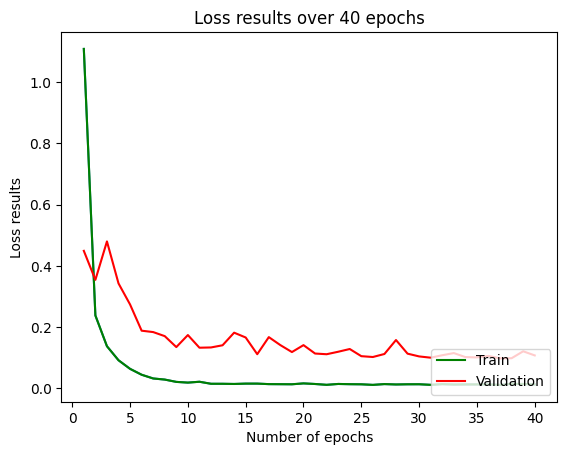

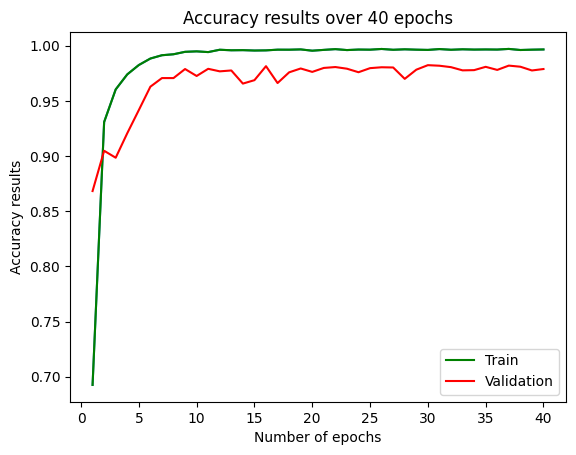

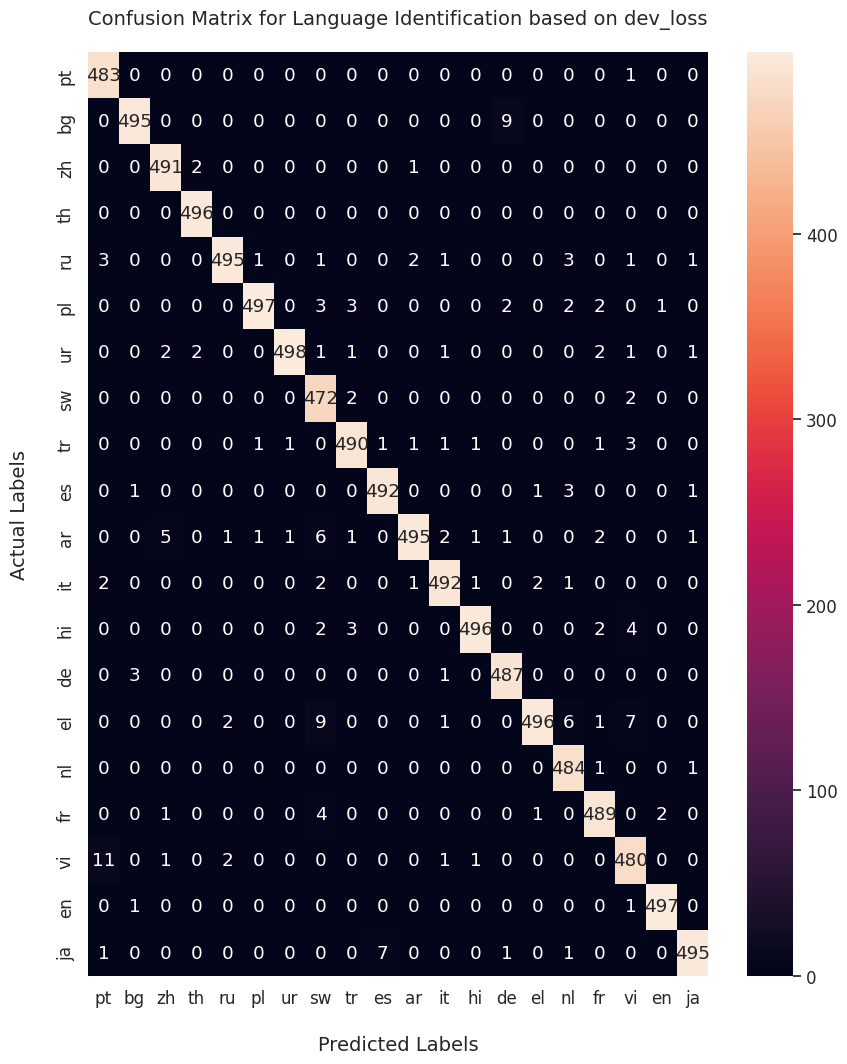

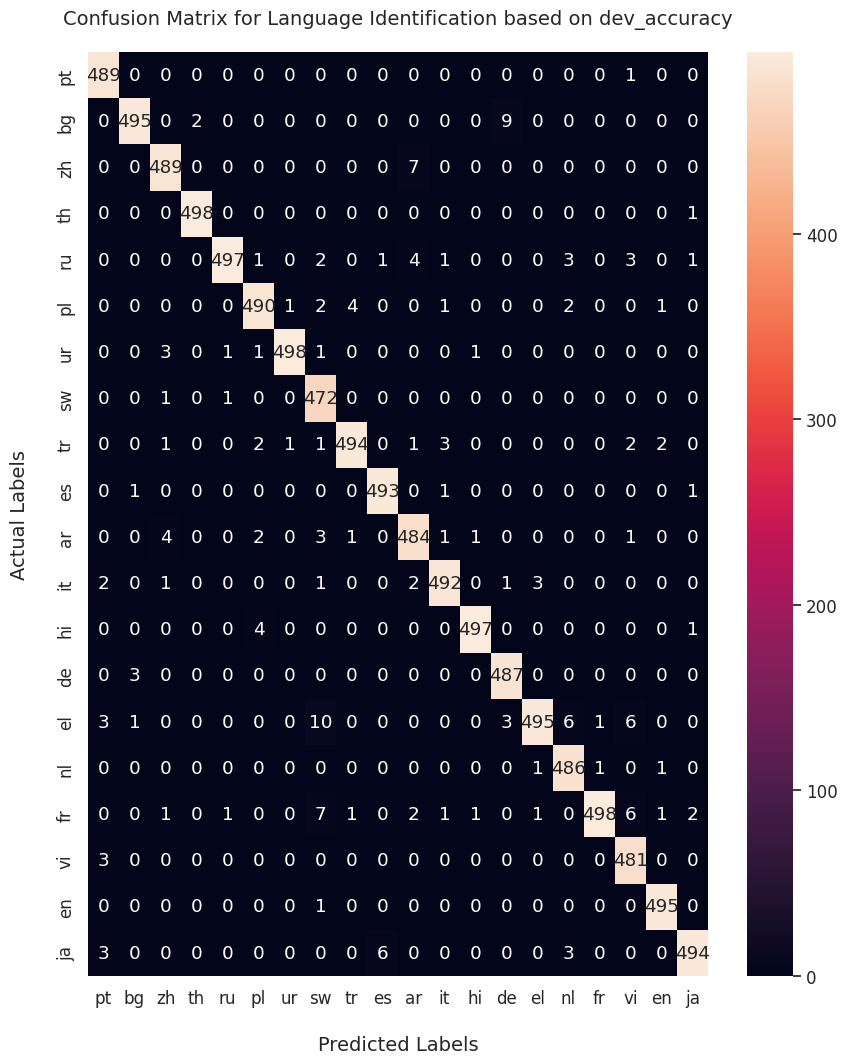

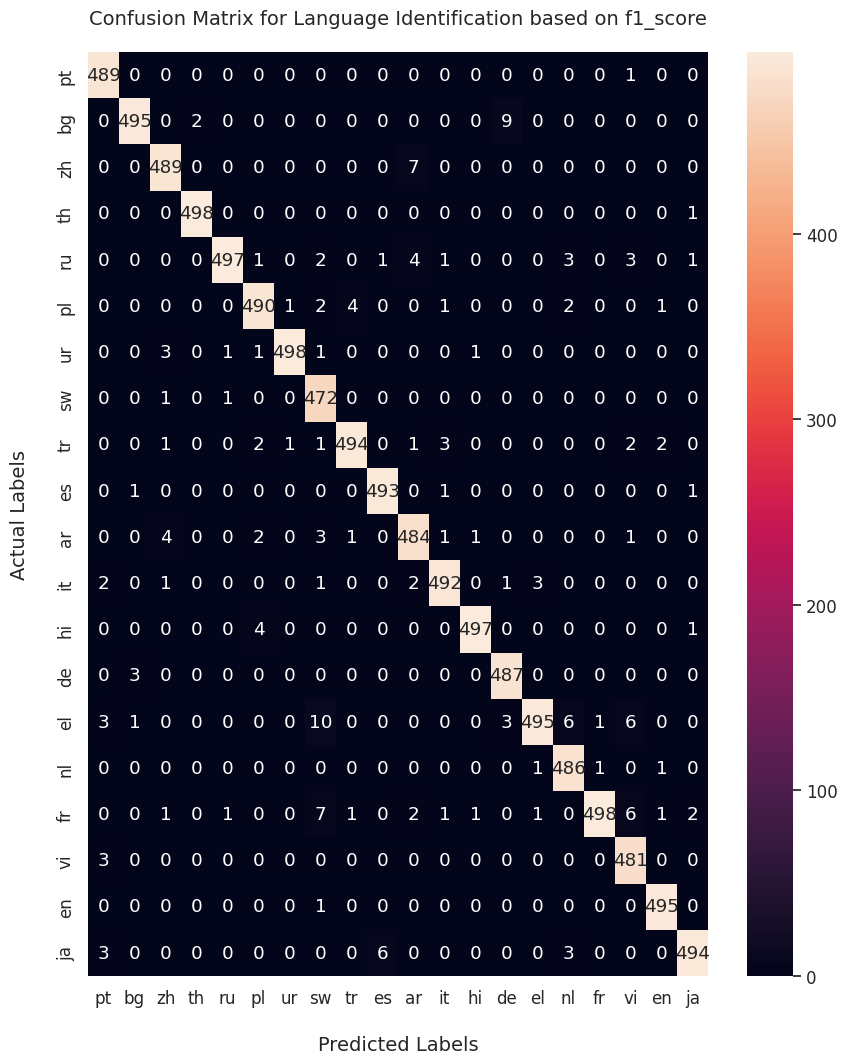

In [ ]:
def __main__() -> None:
    """
    Main function of the project which performs all steps
    :return: None
    """
    processed_dir = 'datasets'
    check_dir(processed_dir)
    input_dir = 'input_data'
    check_dir(input_dir)
    params_dir = 'parameters'
    check_dir(params_dir)
    # project_parameters = get_parameters()
    save_project_parameters(params_dir, project_parameters)
    data_structure = f"structure_{project_parameters['data_structure']}"
    ds_path = os.path.join(processed_dir, data_structure)
    check_dir(ds_path)
    use_words = project_parameters['use_words']
    exp_num = project_parameters['experiment_num']
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data_process = Preprocess(
            use_words=use_words,
            window_size=project_parameters['window_size'],
            window_shift=project_parameters['window_shift'],
            remove_html=project_parameters['html_tags'],
            remove_numbers=project_parameters['numbers'],
            remove_punctuation=project_parameters['punctuation'],
            lower_case=project_parameters['lower']
        )
    dataset = collect_dataset(
            load_path='papluca/language-identification',
            data_process=data_process,
            dataset_dir=ds_path
        )

    vocabulary = Vocabulary(source_dir=ds_path, use_words=use_words)

    statistics = Statistics(
        exp_num=exp_num,
        dataset_dir=ds_path,
        use_words=use_words
    )
    if project_parameters['train']:
        hp = {
            'data_structure': data_structure,
            'emb_dim': project_parameters['embedding_dim'],
            'hid_dim': project_parameters['hidden_dim'],
            'num_classes': len(vocabulary.labels),
            'bidirectional': project_parameters['bidirectional'],
            'dropout': project_parameters['lstm_dropout'],
            'num_layers': project_parameters['num_layers'],
            'max_length': project_parameters['max_length'],
            'learning_rate': project_parameters['learning_rate'],
            'batch_size': project_parameters['batch_size'],
            'weight_decay': project_parameters['weight_decay']
        }
        trainer = Train(
            preprocess=data_process,
            vocabulary=vocabulary,
            hyperparams=hp,
            exp_num=exp_num,
            device=device,
            resume_training=project_parameters['resume_training'],
            load_best=project_parameters['load_best'],
            choice=project_parameters['load_choice'],
            epoch_choice=project_parameters['epoch_choice']
        )
        trainer.training(dataset, project_parameters['epochs'])
    statistics.plot_results()

    if project_parameters['infer']:
        inference = Inference(
            experiment_num=exp_num,
            device=device,
            input_dir=input_dir,
            choice_prompt=project_parameters['from_file'],
            load_best=project_parameters['load_best'],
            choice=project_parameters['load_choice'],
            epoch_choice=project_parameters['epoch_choice'],
        )
        inference.infer_process()



if __name__ == '__main__':
    __main__()

